In [1]:
import numpy as np
import itertools
import json
import time

from pyworld3.pyworld3 import World3
from pyworld3.pyworld3.utils import plot_world_variables
from matplotlib import pyplot as plt


ModuleNotFoundError: No module named 'pyworld3'

Nodes to be changed (PROJECT MILESTONE 2)
1. fioac - fraction of industrial output allocated to consumption [17].yname
2. fcfpc - fertility control facilities per capita [15].xname
3. iopc - industrial output per capita (through iopcd)
4. ppgio - persistent pollution generation industry
5. ehspc - health services per capita [6].xname
6. time 

In [ ]:
def plot_world_3(world3):
    plot_world_variables(
        world3.time,
        [world3.nrfr, world3.iopc, world3.fpc, world3.pop, world3.ppolx],
        ["NRFR", "IOPC", "FPC", "POP", "PPOLX"],
        [[0, 1], [0, 1e3], [0, 1e3], [0, 16e9], [0, 32]],
        figsize=(7, 5),
        grid=1,
        title="Best explored policy - with Network analysis",
    )
    plt.show()

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# evaluation_function evaluates a simulated World3 instance,
# according to some definition of sustainable development.
def evaluation_function(world3):
    population = np.mean(world3.pop)  # population
    nrfr_final = world3.nrfr[-1]  # should be equal to the min
    iopc = np.mean(world3.iopc)  # industrial output per capita
    ppolx = np.mean(world3.ppolx)  # persistent pollution
    fpc = np.mean(world3.fpc)  # food per capita

    print(
        f"obtained population={population}, nrfr_final={nrfr_final}, iopc={iopc}, ppolx={ppolx}, fpc={fpc}"
    )

## We define sustainable development according to those principles:
    # Population: stable, and above a minimum threshold
    # nrfr: as close as possible to initial value
    # iopc: either maximised, or above some threshold
    # ppolx: below some threshold
    # fpc: above some threshold? maximised?
    #
    # We map to numbers between 0-1, that we then multiply. A final score of 1 is best, 0 is worst.
    desired_population = 2e9  # slightly more than the value at the start of the simulation -> no population degrowth
    pop_std = 2e8
    pop_factor = sigmoid((population - desired_population) / pop_std)
    # nrfr can be used as is: 1 means best case, 0 means worst case, and it is linearly impacting the score
    nrfr_factor = nrfr_final

    desired_iopc = 400  # let's just use the default desired values in the 1970s
    iopc_std = 50
    iopc_factor = sigmoid((iopc - desired_iopc) / iopc_std)

    # ppolx is the ratio of the level of pollution w.r.t. what it was in 1970.
    # hence, we want it to be minimized, but not linearly
    # (if it's small, dividing it by 10 doesn't compensate for dividing iopc by 10 for example)
    desired_ppolx = 0.5  # we aim for half as much pollution as there was in 1970
    ppolx_std = 0.2
    ppolx_factor = 1 - sigmoid(
        (ppolx - desired_ppolx) / ppolx_std
    )  # inverted sigmoid: minimize ppolx

    desired_fpc = world3.sfpc * 1.5  # 150% of the subsistance amount
    fpc_std = (
        world3.sfpc / 8
    )  # relatively small std: having less than sfpc should be very bad, while having significantly more shouldn't be much better than having the desired amount
    fpc_factor = sigmoid((fpc - desired_fpc) / fpc_std)

    # w = (pop_n + ppolx_n + nrfr_n + iopc_n + fpc_n) / 6
    # ql = w * (pop_n + ppolx_n + nrfr_n + iopc_n + fpc_n)  # Quality of life

    # print(
    #    f"  yielding pop_factor={pop_factor}, nrfr_factor={nrfr_factor}, iopc_factor={iopc_factor}, ppolx_factor={ppolx_factor}, fpc_factor={fpc_factor}"
    # )

    # Assuming same weight
    ql = pop_factor * nrfr_factor * iopc_factor * ppolx_factor * fpc_factor
    # print(f"result ql: {ql}\n")

    return ql


In [ ]:
def grid_search():
    modified_json_path = "pyworld3/functions_switch_modified"

    parameters_ranges = [
    
        #np.array([1975,1980,2010]),  
        np.array([1975]), #Best Policy
        #np.array ([0.25,0.43,0.6]),#fioac - Society consumes less due to sufficiency lifestyle, or consumption patterns increases
        np.array ([0.43]), #Best Policy
        #np.array ([1000, 500, 2500]),#fcfpc
        np.array ([1000]), #Best Policy
        #np.array([100, 600, 40]),  # iopcd since that influences iopc
        np.array([40]), #Best Policy
        #np.array ([2,6,1]), #ppgio
        np.array ([2]), #Best policy
        #np. array([1000,500,2500]) #ehspc
        np.array ([1000]) #Best Policy
    ]

    #print(f"searching ranges: {parameters_ranges}")
    #total_steps = 1
    #for r in parameters_ranges:
     #   total_steps *= r.shape[0]
    #print(f"total_steps: {total_steps}")

    best_param_set = None
    best_metric = -np.inf

    t1 = None

    for param_set in itertools.product(*parameters_ranges):
        if t1 is None:
            t0 = time.time()

        # open the file
        with open(modified_json_path, "r") as file:
            # Edit the contents of the file object
            data = json.load(file)
            new_data = json.dumps(data)
        # write the file
        with open(modified_json_path, "w") as file:
            file.write(new_data)

        # define a world simulation with this parameter_set
        world3 = World3(pyear=param_set[0])  # choose the time limits and step.
        world3.init_world3_constants(
            fioac1=param_set[1],iopcd = param_set[3],iet=2000)  # choose the model constants.
        
        #Initialising variables (nodes)
        world3.init_world3_variables()
        world3.fcfpc = np.zeros(world3.time.shape)
        world3.fcfpc[0] = param_set[2]

        world3.ppgio = np.zeros(world3.time.shape)
        world3.ppgio[0] = param_set[4]

        world3.ehspc=np.zeros(world3.time.shape)
        world3.ehspc[0]=param_set[5]

        world3.set_world3_table_functions(
            modified_json_path
        )  # get tables from a json file.
        world3.set_world3_delay_functions()  # initialize delay functions.

        # run the simulation
        world3.run_world3()
        
        # evaluate the run according to our notion of sustainable development
        eval_metric = evaluation_function(world3)

        if eval_metric > best_metric:
            best_param_set = param_set
            best_metric = eval_metric
            print(
                f"Found new best param set: {best_param_set}\n    New best metric: {best_metric}"
            )
            plot_world_3(world3)
        print (eval_metric, param_set)

        #if t1 is None:
          #  t1 = time.time()
           # delta_time = t1 - t0
            #print(f"Iteration time: {delta_time}")
            #second_estimation = delta_time * total_steps
            #print(
             #   f"Total estimation: {second_estimation}[s], or {second_estimation / 60} mins."
            #)

    # report results (plot, table, ...)
    #print(f"Best metric: {best_metric}.\nBest param_set: {best_param_set}\n")
    return best_param_set, best_metric


obtained population=2628598794.172296, nrfr_final=0.37430908934773743, iopc=174.61185136093863, ppolx=1.8077310585735922, fpc=445.0109977886547
Found new best param set: (1975, 0.43, 1000, 40, 2, 1000)
    New best metric: 5.481504126690905e-06


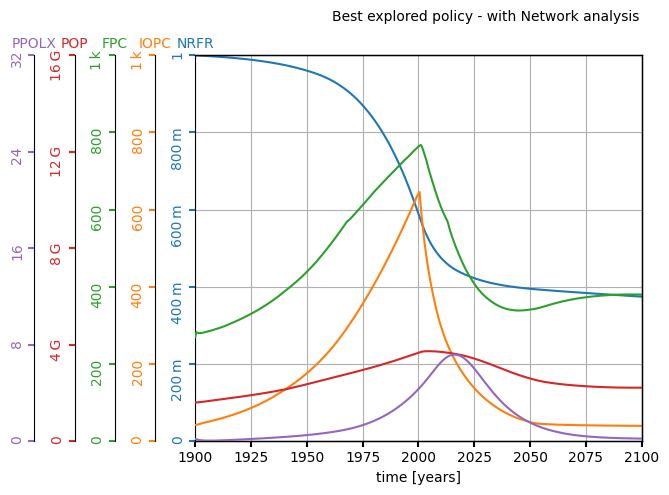

5.481504126690905e-06 (1975, 0.43, 1000, 40, 2, 1000)


In [ ]:
grid_search()

#Explicitely set the others as variables from world3 function
